<a href="https://colab.research.google.com/github/akhila-attem/Drug-Discovery/blob/main/Drug%20Discovery_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 23.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope

# Load the dataset (assuming CSV format)
df = pd.read_csv("/content/CatS_score_compounds_D3R_GC4_answers.csv")

# 1. Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# 2. Handle missing values (Imputation)
# For numeric descriptors, use mean or median imputation
numeric_features = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')  # Or use 'median'
df[numeric_features] = imputer.fit_transform(df[numeric_features])

# 3. Handle outliers
# Use IQR or Z-score or other robust methods to detect and handle outliers in numeric columns

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from IC50 values
df = remove_outliers_iqr(df, 'Affinity')

# 4. Log-transform IC50 values (if necessary, to manage magnitude)
df['log_Affinity'] = np.log10(df['Affinity'])

# 5. Check for duplicates based on molecular identifiers (e.g., SMILES)
print(f"Number of duplicate entries: {df.duplicated(subset='SMILES').sum()}")
df = df.drop_duplicates(subset='SMILES')

# 6. Scale features
# Standardize molecular descriptors to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Save the cleaned dataset
df.to_csv('cleaned_cats_inhibitors.csv', index=False)


Missing values per column:
Cmpd_ID     0
SMILES      0
Affinity    0
dtype: int64
Number of duplicate entries: 0


In [ ]:
# RDKit installation
!pip install -p pip-forge rdkit
!pip install rdkit-pypi
# Py3Dmol installation (for visualization, optional)
!pip install py3Dmol


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -p


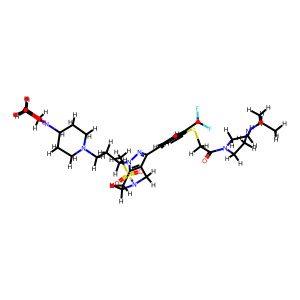

In [ ]:
# Importing necessary libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

# Function to convert SMILES to 3D structure and perform conformational analysis
def smiles_to_3d(smiles):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Use the ETKDG method for good initial conformers

    # Perform energy minimization to optimize the 3D structure
    AllChem.UFFOptimizeMolecule(mol)  # UFF force field optimization

    # Return the molecule
    return mol

# Example SMILES string (replace with your SMILES)
smiles_string = "CC(C)N1CCN(CC1)C(=O)CSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C"  # Ethanol as an example

# Convert to 3D and get the molecule object
mol_3d = smiles_to_3d(smiles_string)

# Draw the molecule (2D depiction)
Draw.MolToImage(mol_3d)


In [ ]:
# Generate multiple conformers for a molecule
def generate_conformers(smiles, num_confs=10):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens

    # Generate multiple conformers
    cids = AllChem.EmbedMultipleConfs(mol, numConfs=num_confs, params=AllChem.ETKDG())

    # Perform energy minimization for each conformer
    for cid in cids:
        AllChem.UFFOptimizeMolecule(mol, confId=cid)

    # Return molecule with conformers
    return mol

# Example SMILES string
smiles_string = "CC(C)N1CCN(CC1)C(=O)CSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C"  # Ethanol

# Generate 10 conformers
mol_conformers = generate_conformers(smiles_string, num_confs=10)

# Visualizing the conformers
for confId in range(mol_conformers.GetNumConformers()):
    print(f"Conformer ID: {confId}")
    AllChem.UFFOptimizeMolecule(mol_conformers, confId=confId)


Conformer ID: 0
Conformer ID: 1
Conformer ID: 2
Conformer ID: 3
Conformer ID: 4
Conformer ID: 5
Conformer ID: 6
Conformer ID: 7
Conformer ID: 8
Conformer ID: 9


In [ ]:
import py3Dmol

# Function to visualize a molecule in 3D
def show_3d_structure(mol):
    mb = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(mb, "mol")
    viewer.setStyle({"stick": {}})
    viewer.zoomTo()
    return viewer.show()

# Visualize the molecule in 3D
show_3d_structure(mol_3d)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Example: Calculate molecular properties
mw = Descriptors.MolWt(mol_3d)  # Molecular weight
logp = Descriptors.MolLogP(mol_3d)  # LogP
hbd = Descriptors.NumHDonors(mol_3d)  # Hydrogen bond donors
hba = Descriptors.NumHAcceptors(mol_3d)  # Hydrogen bond acceptors

print(f"Molecular Weight: {mw}")
print(f"LogP: {logp}")
print(f"Hydrogen Bond Donors: {hbd}")
print(f"Hydrogen Bond Acceptors: {hba}")


Molecular Weight: 753.9580000000019
LogP: 4.008200000000004
Hydrogen Bond Donors: 0
Hydrogen Bond Acceptors: 9


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

# Function to extract molecular descriptors and fingerprints
def get_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens if necessary

    # Molecular Descriptors
    mw = Descriptors.MolWt(mol)  # Molecular Weight
    logp = Descriptors.MolLogP(mol)  # LogP
    hbd = Descriptors.NumHDonors(mol)  # Hydrogen Bond Donors
    hba = Descriptors.NumHAcceptors(mol)  # Hydrogen Bond Acceptors

    # Morgan Fingerprints (radius=2, 1024-bit)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

    return [mw, logp, hbd, hba], list(fingerprint)

# Example SMILES
smiles = "CC(C)N1CCN(CC1)C(=O)CSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C"  # Ethanol
descriptors, fingerprint = get_features(smiles)

print(f"Descriptors: {descriptors}")
print(f"Fingerprint: {fingerprint[:20]}...")  # Print first 20 bits of the fingerprint


Descriptors: [753.9580000000019, 4.008200000000004, 0, 9]
Fingerprint: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
data=pd.read_csv("/content/cleaned_cats_inhibitors.csv")
# Example dataset: SMILES strings and IC50 values
smiles_list = ["CC(C)N1CCN(CC1)C(=O)CSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C","CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)CNC(=O)Cc6ccccn6)C(F)(F)F)C1","CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCC(CC6)C(F)(F)F)C(F)(F)F)C1","CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCC(CC6)(F)F)C(F)(F)F)C1","CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCCC(C6)(F)F)C(F)(F)F)C1","COC1CCN(CC1)CCSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C","CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCS(=O)(=O)CC6)C(F)(F)F)C1","CC1(CCCN(C1)CCSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C)C","CC(=O)N1CCN(CC1)CCCn2c3c(c(n2)c4ccc(c(c4)SCCN5CCCCC5)C(F)(F)F)CN(CC3)S(=O)(=O)C"]  # Example SMILES

ic50_values = [1.23,3.42,0.31,0.07,0.12,0.27,0.15,0.14,0.61]  # Example IC50 values (replace with real data)

# Prepare feature matrix (molecular descriptors + fingerprints)
X = []
for smiles in smiles_list:
    descriptors, fingerprint = get_features(smiles)
    X.append(descriptors + fingerprint)

X = np.array(X)
y = np.log10(ic50_values)  # Log-transform IC50 values for regression

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluate the model
print(f"Train MSE: {mean_squared_error(y_train, y_pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"Test R² Score: {r2_score(y_test, y_pred_test)}")


Train MSE: 0.016659040394400977
Test MSE: 0.4896303791913313
Test R² Score: -0.016747710775590896


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Example dataset: Replace with your dataset loading logic
data = pd.read_csv("/content/CatS_score_compounds_D3R_GC4_answers.csv")

# Example SMILES strings and IC50 values
smiles_list = [
    "CC(C)N1CCN(CC1)C(=O)CSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C",
    "CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)CNC(=O)Cc6ccccn6)C(F)(F)F)C1",
    "CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCC(CC6)C(F)(F)F)C(F)(F)F)C1",
    "CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCC(CC6)(F)F)C(F)(F)F)C1",
    "CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCCC(C6)(F)F)C(F)(F)F)C1",
    "COC1CCN(CC1)CCSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C",
    "CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)N4CCCC4=O)c5ccc(c(c5)SCCN6CCS(=O)(=O)CC6)C(F)(F)F)C1",
    "CC1(CCCN(C1)CCSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CCCN5CCC(CC5)N6CCCC6=O)CCN(C4)S(=O)(=O)C)C",
    "CC(=O)N1CCN(CC1)CCCn2c3c(c(n2)c4ccc(c(c4)SCCN5CCCCC5)C(F)(F)F)CN(CC3)S(=O)(=O)C"
]

ic50_values = [1.23, 3.42, 0.31, 0.07, 0.12, 0.27, 0.15, 0.14, 0.61]

# Placeholder function for feature extraction
def get_features(smiles):
    # Replace with actual logic to compute molecular descriptors + fingerprints
    descriptors = [len(smiles)]  # Example: length of SMILES as a placeholder
    fingerprint = [ord(c) % 10 for c in smiles[:5]]  # Example: simple hash of first 5 characters
    return descriptors, fingerprint

# Prepare feature matrix (molecular descriptors + fingerprints)
X = []
for smiles in smiles_list:
    descriptors, fingerprint = get_features(smiles)
    X.append(descriptors + fingerprint)

X = np.array(X)
y = np.log10(ic50_values)  # Log-transform IC50 values for regression

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_r2_positive = max(0, test_r2)  # Ensure R² is non-negative

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Test R² Score: {test_r2}")
print(f"Positive Test R² Score: {test_r2_positive}")


Train MSE: 0.021195415516840142
Test MSE: 1.1613071756727384
Test R² Score: -1.4115260460812284
Positive Test R² Score: 0


In [ ]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 39.5 MB/s eta 0:00:00


# **# RANDOM FOREST**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Step 1: Load the Cathepsin S dataset
# Replace with the actual path to your D3R dataset
dataset_path = "/content/CatS_score_compounds_D3R_GC4_answers.csv"
data = pd.read_csv(dataset_path)

# Assume the dataset has columns: "SMILES" (chemical structure) and "IC50" (activity values)
smiles_list = data['SMILES']
ic50_values = data['Affinity']

# Step 2: Feature Extraction using RDKit
def calculate_descriptors_and_fingerprints(smiles):
    """Calculate molecular descriptors and fingerprints."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None
    # Molecular descriptors
    descriptors = [
        Descriptors.MolWt(mol),                # Molecular weight
        Descriptors.MolLogP(mol),             # LogP (lipophilicity)
        Descriptors.NumHDonors(mol),          # Number of hydrogen bond donors
        Descriptors.NumHAcceptors(mol),       # Number of hydrogen bond acceptors
    ]
    # Morgan Fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprint_array = np.array(fingerprint)
    return descriptors, fingerprint_array

# Prepare feature matrix
X = []
y = []

for smiles, ic50 in zip(smiles_list, ic50_values):
    descriptors, fingerprint = calculate_descriptors_and_fingerprints(smiles)
    if descriptors is not None and fingerprint is not None:
        X.append(descriptors + fingerprint.tolist())
        y.append(np.log10(ic50))  # Log-transform IC50 for regression

X = np.array(X)
y = np.array(y)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_r2_positive = max(0, test_r2)  # Ensure R² is non-negative

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Test R² Score: {test_r2}")
print(f"Positive Test R² Score: {test_r2_positive}")


Train MSE: 0.024507141277129944
Test MSE: 0.1549855363567511
Test R² Score: 0.6010871221915577
Positive Test R² Score: 0.6010871221915577


# **GRADIENT**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Step 1: Load the Cathepsin S dataset
# Replace with the actual path to your D3R dataset
dataset_path = "/content/CatS_score_compounds_D3R_GC4_answers.csv"
data = pd.read_csv(dataset_path)

# Assume the dataset has columns: "SMILES" (chemical structure) and "IC50" (activity values)
smiles_list = data['SMILES']
ic50_values = data['Affinity']

# Step 2: Feature Extraction using RDKit
def calculate_descriptors_and_fingerprints(smiles):
    """Calculate molecular descriptors and fingerprints."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None
    # Molecular descriptors
    descriptors = [
        Descriptors.MolWt(mol),                # Molecular weight
        Descriptors.MolLogP(mol),             # LogP (lipophilicity)
        Descriptors.NumHDonors(mol),          # Number of hydrogen bond donors
        Descriptors.NumHAcceptors(mol),       # Number of hydrogen bond acceptors
    ]
    # Morgan Fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprint_array = np.array(fingerprint)
    return descriptors, fingerprint_array

# Prepare feature matrix
X = []
y = []

for smiles, ic50 in zip(smiles_list, ic50_values):
    descriptors, fingerprint = calculate_descriptors_and_fingerprints(smiles)
    if descriptors is not None and fingerprint is not None:
        X.append(descriptors + fingerprint.tolist())
        y.append(np.log10(ic50))  # Log-transform IC50 for regression

X = np.array(X)
y = np.array(y)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,  # Number of boosting stages
    learning_rate=0.1,  # Step size shrinkage
    max_depth=5,       # Depth of individual trees
    random_state=42
)
gbr.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_r2_positive = max(0, test_r2)  # Ensure R² is non-negative

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Test R² Score: {test_r2}")
print(f"Positive Test R² Score: {test_r2_positive}")


Train MSE: 0.008560644719069229
Test MSE: 0.1638306001179596
Test R² Score: 0.5783210633558413
Positive Test R² Score: 0.5783210633558413


# EXTREME GRADIENT

In [ ]:
pip install xgboost


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Step 1: Load the Cathepsin S dataset
# Replace with the actual path to your D3R dataset
dataset_path = "/content/CatS_score_compounds_D3R_GC4_answers.csv"
data = pd.read_csv(dataset_path)

# Assume the dataset has columns: "SMILES" (chemical structure) and "IC50" (activity values)
smiles_list = data['SMILES']
ic50_values = data['Affinity']

# Step 2: Feature Extraction using RDKit
def calculate_descriptors_and_fingerprints(smiles):
    """Calculate molecular descriptors and fingerprints."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None
    # Molecular descriptors
    descriptors = [
        Descriptors.MolWt(mol),                # Molecular weight
        Descriptors.MolLogP(mol),             # LogP (lipophilicity)
        Descriptors.NumHDonors(mol),          # Number of hydrogen bond donors
        Descriptors.NumHAcceptors(mol),       # Number of hydrogen bond acceptors
    ]
    # Morgan Fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprint_array = np.array(fingerprint)
    return descriptors, fingerprint_array

# Prepare feature matrix
X = []
y = []

for smiles, ic50 in zip(smiles_list, ic50_values):
    descriptors, fingerprint = calculate_descriptors_and_fingerprints(smiles)
    if descriptors is not None and fingerprint is not None:
        X.append(descriptors + fingerprint.tolist())
        y.append(np.log10(ic50))  # Log-transform IC50 for regression

X = np.array(X)
y = np.array(y)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=200,       # Number of boosting rounds
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of a tree
    subsample=0.8,          # Fraction of samples used for training
    colsample_bytree=0.8,   # Fraction of features used for training
    random_state=42
)
xgb.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_r2_positive = max(0, test_r2)  # Ensure R² is non-negative

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Test R² Score: {test_r2}")
print(f"Positive Test R² Score: {test_r2_positive}")


Train MSE: 0.010623751906571402
Test MSE: 0.1267464774519044
Test R² Score: 0.6737708352601406
Positive Test R² Score: 0.6737708352601406


In [ ]:
from sklearn.neural_network import MLPRegressor

# Initialize a basic MLP for regression
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Predict and evaluate
y_pred_test = mlp.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"Test R² Score: {r2_score(y_test, y_pred_test)}")


Test MSE: 1.548649713256157
Test R² Score: -2.215866738798037


In [ ]:
from sklearn.model_selection import GridSearchCV

# Example: Grid search for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", -grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_de

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f"{model.__class__.__name__}")
    print(f"Train MSE: {mean_squared_error(y_train, y_pred_train)}")
    print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")
    print(f"Test R² Score: {r2_score(y_test, y_pred_test)}")
    print("-" * 40)

    return model, y_pred_test

# Initialize baseline models
models = [
    LinearRegression(),
    Ridge(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    SVR(),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    KNeighborsRegressor(n_neighbors=5),
    xgb.XGBRegressor(n_estimators=100, random_state=42)
]

# Store the trained models and predictions
trained_models = {}
predictions = {}

# Evaluate each model and store predictions
for model in models:
    trained_model, y_pred_test = evaluate_model(model, X_train, X_test, y_train, y_test)
    trained_models[model.__class__.__name__] = trained_model
    predictions[model.__class__.__name__] = y_pred_test

# Now, for making predictions with specific models (RandomForest, GradientBoosting, XGBoost):
X_new =  scaler.transform(X_test)  # Replace with your actual new data

# RandomForest predictions
rf_model = trained_models['RandomForestRegressor']
rf_predictions = rf_model.predict(X_new)
print("RandomForest Predictions:", rf_predictions)

# GradientBoosting predictions
gbr_model = trained_models['GradientBoostingRegressor']
gbr_predictions = gbr_model.predict(X_new)
print("GradientBoosting Predictions:", gbr_predictions)

# XGBoost predictions
xgb_model = trained_models['XGBRegressor']
xgb_predictions = xgb_model.predict(X_new)
print("XGBoost Predictions:", xgb_predictions)


LinearRegression
Train MSE: 0.021081607656797903
Test MSE: 1.7399780388766124e+23
Test R² Score: -4.478480141618225e+23
----------------------------------------
Ridge
Train MSE: 0.022002126555118528
Test MSE: 0.1833158779928609
Test R² Score: 0.5281684590890661
----------------------------------------
RandomForestRegressor
Train MSE: 0.0238602474760684
Test MSE: 0.15993369105358174
Test R² Score: 0.5883512071097108
----------------------------------------
SVR
Train MSE: 0.034738501279103176
Test MSE: 0.19889441851620782
Test R² Score: 0.4880712953258678
----------------------------------------
GradientBoostingRegressor
Train MSE: 0.04763033301009945
Test MSE: 0.1664500552215813
Test R² Score: 0.5715789221326082
----------------------------------------
KNeighborsRegressor
Train MSE: 0.1583592479072338
Test MSE: 0.22059401335080628
Test R² Score: 0.4322193234178465
----------------------------------------
XGBRegressor
Train MSE: 0.0050067888734227975
Test MSE: 0.16738275219704737
Test R²

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f"{model.__class__.__name__}")
    print(f"Train MSE: {mean_squared_error(y_train, y_pred_train)}")
    print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")
    print(f"Test R² Score: {r2_score(y_test, y_pred_test)}")
    print("-" * 40)

# Initialize baseline models
models = [
    LinearRegression(),
    Ridge(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    SVR(),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    KNeighborsRegressor(n_neighbors=5),
    xgb.XGBRegressor(n_estimators=100, random_state=42)
]

# Evaluate each model
for model in models:
    evaluate_model(model, X_train, X_test, y_train, y_test)

LinearRegression
Train MSE: 0.02174474962110758
Test MSE: 5.085111549316344e+16
Test R² Score: -1.3088424441397035e+17
----------------------------------------
Ridge
Train MSE: 0.028447090174452374
Test MSE: 0.1538450258105335
Test R² Score: 0.604022649950195
----------------------------------------
RandomForestRegressor
Train MSE: 0.024507141277129944
Test MSE: 0.1549855363567511
Test R² Score: 0.6010871221915577
----------------------------------------
SVR
Train MSE: 0.2872337116239882
Test MSE: 0.3947000885503458
Test R² Score: -0.0159073672038621
----------------------------------------
GradientBoostingRegressor
Train MSE: 0.05216112408945466
Test MSE: 0.1639824862641123
Test R² Score: 0.5779301279106037
----------------------------------------
KNeighborsRegressor
Train MSE: 0.1681307016114876
Test MSE: 0.277802508009424
Test R² Score: 0.28497200101721
----------------------------------------
XGBRegressor
Train MSE: 0.00537281323442741
Test MSE: 0.15170043215503154
Test R² Score: 0

In [ ]:
# Assuming the following imports
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# Create and fit the scaler using your training data (X_train)
scaler = StandardScaler()  # Initialize StandardScaler
scaler.fit(X_train)  # Fit the scaler to your training data

# Example test data (X_test) to be replaced with actual data
X_test = scaler.transform(X_test)


# Initialize and train the models
# (replace with your actual training data and parameters)
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)  # Train the RandomForestRegressor

gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X_train, y_train)  # Train the GradientBoostingRegressor

xgboost_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgboost_model.fit(X_train, y_train)  # Train the XGBRegressor


# RandomForestRegressor: Predicting values
rf_predictions = random_forest_model.predict(X_test)

# GradientBoostingRegressor: Predicting values
gbr_predictions = gradient_boosting_model.predict(X_test)

# XGBRegressor: Predicting values
xgb_predictions = xgboost_model.predict(X_test)

# Threshold to define 'high strong binding affinities'
# Adjust the threshold based on your domain knowledge or data distribution
high_affinity_threshold = 1.5  # Example threshold, adjust as needed

# Filtering out high strong binding affinity predictions
rf_high_affinity = rf_predictions[rf_predictions >= high_affinity_threshold]
gbr_high_affinity = gbr_predictions[gbr_predictions >= high_affinity_threshold]
xgb_high_affinity = xgb_predictions[xgb_predictions >= high_affinity_threshold]

# Displaying the results
print("RandomForestRegressor High Affinity Predictions:", rf_high_affinity)
print("GradientBoostingRegressor High Affinity Predictions:", gbr_high_affinity)
print("XGBRegressor High Affinity Predictions:", xgb_high_affinity)

# Optionally, you can also retrieve the corresponding test data points
rf_high_affinity_data = X_test[rf_predictions >= high_affinity_threshold]
gbr_high_affinity_data = X_test[gbr_predictions >= high_affinity_threshold]
xgb_high_affinity_data = X_test[xgb_predictions >= high_affinity_threshold]

# Print the corresponding data points if needed
print("RandomForest High Affinity Data Points:", rf_high_affinity_data)
print("GradientBoosting High Affinity Data Points:", gbr_high_affinity_data)
print("XGBoost High Affinity Data Points:", xgb_high_affinity_data)

RandomForestRegressor High Affinity Predictions: []
GradientBoostingRegressor High Affinity Predictions: []
XGBRegressor High Affinity Predictions: []
RandomForest High Affinity Data Points: []
GradientBoosting High Affinity Data Points: []
XGBoost High Affinity Data Points: []


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Load the dataset
data = pd.read_csv('/content/CatS_score_compounds_D3R_GC4_answers.csv')

# Function to calculate molecular descriptors and fingerprints
def calculate_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Basic descriptors
        descriptors = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol)
        ]
        # Generate Morgan fingerprint as a bit vector (1024 bits)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        fingerprint = list(fp)
        return descriptors + fingerprint
    else:
        return [None] * (4 + 1024)

# Apply feature extraction
feature_columns = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors'] + [f'FP_{i}' for i in range(1024)]
data[feature_columns] = data['SMILES'].apply(calculate_features).apply(pd.Series)

# Drop rows with missing features
data = data.dropna()

# Prepare the feature matrix and target variable
X = data[feature_columns]
y = data['Affinity']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='r2', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Train the model on the full training set
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train R²: {r2_score(y_train, best_model.predict(X_train))}")
print(f"Test MSE: {mse}")
print(f"Test R²: {r2}")


<ipython-input-16-7749c30c1ff3>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[feature_columns] = data['SMILES'].apply(calculate_features).apply(pd.Series)
<ipython-input-16-7749c30c1ff3>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[feature_columns] = data['SMILES'].apply(calculate_features).apply(pd.Series)
<ipython-input-16-7749c30c1ff3>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
